In [1]:
import os 

path = 'data/eopatches/test'
patches = os.listdir(path)
len(patches)

25

In [4]:
from tqdm import tqdm 
import gzip 
import numpy as np
from skimage.transform import resize
import rasterio 
from rasterio.profiles import DefaultGTiffProfile
from eolearn.core import EOPatch

submission_path = 'submission'
thresholds = (0.4, 0.6)
for patch in tqdm(patches):

    # load bands
    file_path = f'{path}/{patch}/data/BANDS.npy.gz'
    f = gzip.GzipFile(file_path, "r")
    bands = np.load(f)

    # compute mean ndvi
    ndvis = []
    for step in range(bands.shape[0]):
        b8 = bands[...,7][step].astype(float)
        b4 = bands[...,3][step].astype(float)
        ndvi = (b8 - b4) / (b8 + b4)
        ndvis.append(ndvi)
    mean_ndvi = np.mean(ndvis, axis=0)

    # compute target mask
    target = (mean_ndvi >= thresholds[0]) & (ndvi <= thresholds[1])

    # resize
    big_target = resize(target, (2000, 2000)).astype(bool)

    # save
    file_path = f'{path}/{patch}'
    eopatch = EOPatch.load(file_path)
    # Gracias a @cayala
    tfm = rasterio.transform.from_bounds(*eopatch.bbox, eopatch.meta_info['size_x'], eopatch.meta_info['size_y'])
    tfm = rasterio.Affine(tfm.a/4, tfm.b, tfm.c, tfm.d, tfm.e/4, tfm.f)
    profile = DefaultGTiffProfile(count=1)
    profile.update(
        transform=tfm,
        width=2000,
        height=2000,
        crs='epsg:32633'
    )
    with rasterio.open(f'{submission_path}/{patch}.tif', 'w', **profile) as dst_dataset:
        dst_dataset.write(big_target, 1)
    

 16%|█▌        | 4/25 [00:08<00:38,  1.82s/it]/tmp/ipykernel_105513/3055946765.py:23: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (b8 - b4) / (b8 + b4)
100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


In [5]:
!tar -C {submission_path} -zcvf submission.tar.gz .

./
./eopatch-23.tif
./eopatch-17.tif
./eopatch-21.tif
./eopatch-11.tif
./eopatch-18.tif
./eopatch-12.tif
./eopatch-25.tif
./eopatch-13.tif
./eopatch-08.tif
./eopatch-10.tif
./eopatch-22.tif
./eopatch-09.tif
./eopatch-20.tif
./eopatch-19.tif
./eopatch-02.tif
./eopatch-06.tif
./eopatch-14.tif
./eopatch-03.tif
./eopatch-05.tif
./eopatch-16.tif
./eopatch-04.tif
./eopatch-15.tif
./eopatch-01.tif
./eopatch-07.tif
./eopatch-24.tif


In [14]:
mean_ndvi.shape, mean_ndvi.dtype, mean_ndvi.max(), mean_ndvi.min()

((500, 500), dtype('float64'), nan, nan)

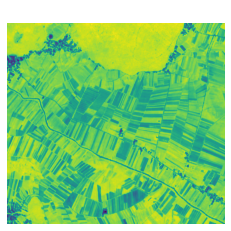

In [15]:
import matplotlib.pyplot as plt

plt.imshow(mean_ndvi)
plt.axis('off')
plt.show()

In [16]:
big_target.shape, big_target.dtype, big_target.max(), big_target.min()

((2000, 2000), dtype('bool'), True, False)

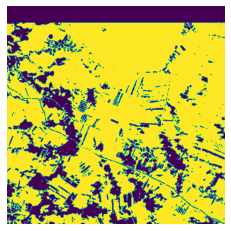

In [17]:
plt.imshow(big_target)
plt.axis('off')
plt.show()

In [18]:
sample = 'eopatch-03'
mask_ds = rasterio.open(f'submission/{sample}.tif')
mask_ds.crs, mask_ds.bounds

(CRS.from_epsg(32633),
 BoundingBox(left=746400.0, bottom=4508000.0, right=751400.0, top=4513000.0))

In [19]:
eopatch = EOPatch.load(f'{path}/{sample}')
print(eopatch.bbox)

746400.0,4508000.0,751400.0,4513000.0


In [20]:
mask = mask_ds.read(1)
mask.dtype, mask.shape, mask.min(), mask.max()

(dtype('uint8'), (2000, 2000), 0, 1)

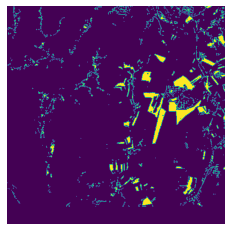

In [21]:
plt.imshow(mask)
plt.axis('off')
plt.show()